In [1]:
#
# Quantum Convolutional Neural Network for Image Classification 
#
# Alexis A. Gomez, Dr. Artyom Grigoryan,
# UTSA ECE, August 16, 2024,
#
# Reference:
# Quantum Image Processing: A Mathematical Toolbox by Artyom M. Grigoryan and Sos Agaian

# Import Dependencies
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split


In [2]:
def create_zfeaturemap(num_qubits, feature_vector, iteration=1):
    """
    Create a quantum circuit implementing a ZFeatureMap.
    
    This function constructs a quantum circuit that encodes classical data into quantum states using
    Hadamard and Z rotation gates. The feature map can be applied multiple times to deepen the encoding.
    
    Parameters:
        num_qubits (int): The number of qubits in the circuit, which should match the length of the feature vector.
        feature_vector (list or array): A vector of classical data points to be encoded into the quantum states.
        iteration (int): The number of times the feature map is applied. Default is 1.
    
    Returns:
        QuantumCircuit: A quantum circuit implementing the ZFeatureMap for the given data.
    """
    # Initialize the quantum circuit with the specified number of qubits
    qc = QuantumCircuit(num_qubits)
    
    # Apply the feature map the specified number of iterations
    for _ in range(iteration):
        # Apply a Hadamard gate to each qubit to create superposition
        for i in range(num_qubits):
            qc.h(i)
    
        # Apply a Z rotation to each qubit based on the corresponding feature
        for i in range(num_qubits):
            theta = feature_vector[i] * np.pi  # Pi times the feature value
            qc.rz(theta, i)
    
    # Return the constructed quantum circuit
    return qc

# Example usage:
num_qubits = 4  # Specifies the number of qubits and hence features
feature_vector = [0.1, 0.5, 0.8, 0.3]  # Example feature values to encode

# Create the ZFeatureMap circuit with 2 iterations for deeper encoding
qc = create_zfeaturemap(num_qubits, feature_vector, 2)

# Print the quantum circuit
print(qc)

     ┌───┐ ┌──────────┐┌───┐ ┌──────────┐
q_0: ┤ H ├─┤ Rz(π/10) ├┤ H ├─┤ Rz(π/10) ├
     ├───┤ ├─────────┬┘├───┤ ├─────────┬┘
q_1: ┤ H ├─┤ Rz(π/2) ├─┤ H ├─┤ Rz(π/2) ├─
     ├───┤ ├─────────┴┐├───┤ ├─────────┴┐
q_2: ┤ H ├─┤ Rz(4π/5) ├┤ H ├─┤ Rz(4π/5) ├
     ├───┤┌┴──────────┤├───┤┌┴──────────┤
q_3: ┤ H ├┤ Rz(3π/10) ├┤ H ├┤ Rz(3π/10) ├
     └───┘└───────────┘└───┘└───────────┘


In [3]:
def conv_circuit(params):
    """
    Create a two-qubit convolutional-like unitary circuit.

    This function constructs a quantum circuit that performs a series of rotations
    and entangling operations, representing a convolutional layer in a quantum neural network.

    Parameters:
        params (list or ParameterVector): A vector of parameters (θ_0, θ_1, θ_2) used in the gate rotations.
    
    Returns:
        QuantumCircuit: A 2-qubit quantum circuit implementing the convolutional-like unitary.
    """
    # Initialize a 2-qubit Quantum Circuit
    circuit = QuantumCircuit(2)
    
    # Apply a Rz rotation of -π/2 on the second qubit
    circuit.rz(-np.pi / 2, 1)
    
    # Apply a CNOT gate with qubit 1 as control and qubit 0 as target
    circuit.cx(1, 0)
    
    # Apply a Rz rotation parameterized by θ_0 on the first qubit
    circuit.rz(params[0], 0)
    
    # Apply a Ry rotation parameterized by θ_1 on the second qubit
    circuit.ry(params[1], 1)
    
    # Apply a CNOT gate with qubit 0 as control and qubit 1 as target
    circuit.cx(0, 1)
    
    # Apply a Ry rotation parameterized by θ_2 on the second qubit
    circuit.ry(params[2], 1)
    
    # Apply another CNOT gate with qubit 1 as control and qubit 0 as target
    circuit.cx(1, 0)
    
    # Apply a Rz rotation of π/2 on the first qubit
    circuit.rz(np.pi / 2, 0)
    
    # Return the complete circuit
    return circuit

# Create a ParameterVector to hold the parameters for the unitary
params = ParameterVector("θ", length=3)

# Generate the circuit with the specified parameters
circuit = conv_circuit(params)

# Print the quantum circuit
print(circuit)

                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■─────────────
     └──────────┘     └──────────┘└───┘└──────────┘                


In [4]:
def create_convolutional_layer(total_qubits, parameter_prefix):
    """
    Construct a quantum convolutional layer for a QCNN.

    This function builds a quantum circuit that applies a convolutional-like operation across qubits.
    It uses a predefined two-qubit unitary gate (defined elsewhere as conv_circuit) across pairs of qubits.

    Parameters:
        total_qubits (int): Total number of qubits in the circuit.
        parameter_prefix (str): Prefix for the parameter names used in the parameterized gates.

    Returns:
        QuantumCircuit: A quantum circuit representing the convolutional layer of a QCNN.
    """
    # Initialize a quantum circuit named 'Convolutional Layer'
    conv_layer = QuantumCircuit(total_qubits, name="Convolutional Layer")
    
    # Create a list of qubits for applying gates
    qubit_list = list(range(total_qubits))
    
    # Initialize parameter index and create a vector of parameters
    current_param_index = 0
    parameters = ParameterVector(parameter_prefix, length=total_qubits * 3)
    
    # Apply the convolutional operation to each pair of adjacent qubits
    # Start with even-indexed qubits paired with the next odd-indexed qubits
    for first_qubit, second_qubit in zip(qubit_list[0::2], qubit_list[1::2]):
        conv_layer = conv_layer.compose(conv_circuit(parameters[current_param_index:current_param_index + 3]),
                                        [first_qubit, second_qubit])
        conv_layer.barrier()
        current_param_index += 3

    # Continue with odd-indexed qubits paired with the next qubit, wrapping around
    for first_qubit, second_qubit in zip(qubit_list[1::2], qubit_list[2::2] + [0]):
        conv_layer = conv_layer.compose(conv_circuit(parameters[current_param_index:current_param_index + 3]),
                                        [first_qubit, second_qubit])
        conv_layer.barrier()
        current_param_index += 3

    # Convert the layer to an instruction for reusability
    conv_layer_instruction = conv_layer.to_instruction()

    # Create a new circuit and append the convolutional layer instruction
    final_circuit = QuantumCircuit(total_qubits)
    final_circuit.append(conv_layer_instruction, qubit_list)

    return final_circuit

# Example usage: creating and drawing a convolutional layer with 4 qubits
circuit = create_convolutional_layer(4, "theta")

# Print the quantum circuit
print(circuit.decompose())

                 ┌───┐┌──────────────┐                     ┌───┐┌─────────┐ ░ »
q_0: ────────────┤ X ├┤ Rz(theta[0]) ├──■──────────────────┤ X ├┤ Rz(π/2) ├─░─»
     ┌──────────┐└─┬─┘├──────────────┤┌─┴─┐┌──────────────┐└─┬─┘└─────────┘ ░ »
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ Ry(theta[2]) ├──■──────────────░─»
     └──────────┘     └──────────────┘└───┘└──────────────┘                 ░ »
q_2: ───────────────────────────────────────────────────────────────────────░─»
                                                                            ░ »
q_3: ───────────────────────────────────────────────────────────────────────░─»
                                                                            ░ »
«                                                                            ░ »
«q_0: ───────────────────────────────────────────────────────────────────────░─»
«                                                                            ░ »
«q_1: ───────────────────────────────

In [5]:
def pool_circuit(params):
    """
    Create a two-qubit pooling circuit for a quantum neural network.

    This function constructs a quantum circuit that combines the states of two qubits into a single qubit
    through a series of rotations and CNOT gates. This process is analogous to classical neural network pooling,
    reducing the effective number of qubits while retaining critical quantum information.

    Parameters:
        params (ParameterVector): A vector of parameters (θ_0, θ_1, θ_2) used in the gate rotations.

    Returns:
        QuantumCircuit: A 2-qubit quantum circuit intended for use as a pooling layer in a QCNN.
    """
    # Initialize a 2-qubit Quantum Circuit
    circuit = QuantumCircuit(2)
    
    # Apply a Rz rotation of -π/2 on the second qubit to set the phase
    circuit.rz(-np.pi / 2, 1)
    
    # Apply a CNOT gate with qubit 1 as control and qubit 0 as target to start entangling
    circuit.cx(1, 0)
    
    # Apply a Rz rotation parameterized by θ_0 on the first qubit
    circuit.rz(params[0], 0)
    
    # Apply a Ry rotation parameterized by θ_1 on the second qubit
    circuit.ry(params[1], 1)
    
    # Apply a CNOT gate with qubit 0 as control and qubit 1 as target for further entanglement
    circuit.cx(0, 1)
    
    # Apply a Ry rotation parameterized by θ_2 on the second qubit
    circuit.ry(params[2], 1)

    # Return the complete circuit
    return circuit

# Create a ParameterVector to hold the parameters for the unitary
params = ParameterVector("θ", length=3)

# Generate the circuit with the specified parameters
circuit = pool_circuit(params)

# Print the quantum circuit
print(circuit)

                 ┌───┐┌──────────┐                 
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├
     └──────────┘     └──────────┘└───┘└──────────┘


In [6]:
def create_pooling_layer(source_qubits, sink_qubits, parameter_prefix):
    """
    Construct a quantum pooling layer using a pre-defined pooling unitary.

    This function builds a quantum circuit that reduces the number of effective qubits 
    by pooling the information from 'source' qubits into 'sink' qubits using a parameterized
    two-qubit gate. Each pair of source and sink qubits undergoes this transformation.

    Parameters:
        source_qubits (list): Indices of source qubits.
        sink_qubits (list): Indices of sink qubits, which will pair with source qubits.
        parameter_prefix (str): Prefix for the parameter names used in the parametrized gates.

    Returns:
        QuantumCircuit: A quantum circuit representing the pooling layer of a QCNN.
    """
    # Determine the total number of qubits based on source and sink lists
    num_qubits = len(source_qubits) + len(sink_qubits)
    
    # Initialize a quantum circuit with a name 'Pooling Layer'
    pooling_layer = QuantumCircuit(num_qubits, name="Pooling Layer")
    
    # Create a vector of parameters for the gates, assuming three parameters per pair
    parameters = ParameterVector(parameter_prefix, length=len(source_qubits) * 3)
    current_param_index = 0
    
    # Apply the pooling unitary to each pair of source and sink qubits
    for source, sink in zip(source_qubits, sink_qubits):
        # Compose the pooling circuit with the current pair of qubits
        pooling_layer = pooling_layer.compose(
            pool_circuit(parameters[current_param_index:current_param_index + 3]), 
            [source, sink]
        )
        pooling_layer.barrier()
        current_param_index += 3

    # Convert the layer to an instruction for modular use
    pooling_layer_instruction = pooling_layer.to_instruction()

    # Create a new circuit and append the pooling layer instruction
    final_circuit = QuantumCircuit(num_qubits)
    final_circuit.append(pooling_layer_instruction, range(num_qubits))

    return final_circuit

# Example usage: Create a pooling layer with specified source and sink qubits
source_qubits = [0, 1]
sink_qubits = [2, 3]
circuit = create_pooling_layer(source_qubits, sink_qubits, "theta")

# Print the quantum circuit
print(circuit.decompose())

                 ┌───┐┌──────────────┐                      ░                  »
q_0: ────────────┤ X ├┤ Rz(theta[0]) ├──■───────────────────░──────────────────»
                 └─┬─┘└──────────────┘  │                   ░             ┌───┐»
q_1: ──────────────┼────────────────────┼───────────────────░─────────────┤ X ├»
     ┌──────────┐  │  ┌──────────────┐┌─┴─┐┌──────────────┐ ░             └─┬─┘»
q_2: ┤ Rz(-π/2) ├──■──┤ Ry(theta[1]) ├┤ X ├┤ Ry(theta[2]) ├─░───────────────┼──»
     └──────────┘     └──────────────┘└───┘└──────────────┘ ░ ┌──────────┐  │  »
q_3: ───────────────────────────────────────────────────────░─┤ Rz(-π/2) ├──■──»
                                                            ░ └──────────┘     »
«                                           ░ 
«q_0: ──────────────────────────────────────░─
«     ┌──────────────┐                      ░ 
«q_1: ┤ Rz(theta[3]) ├──■───────────────────░─
«     └──────────────┘  │                   ░ 
«q_2: ──────────────────┼───────────

In [7]:
# Initialize the feature map for the quantum neural network
feature_map = ZFeatureMap(8)

# Create an Ansatz circuit named 'Ansatz' for structuring the QNN layers
ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer: Applies a convolutional layer across all 8 qubits
ansatz.compose(create_convolutional_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer: Reduces dimensionality by pooling pairs of qubits
ansatz.compose(create_pooling_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer: Applies another convolutional layer to the second set of 4 qubits
ansatz.compose(create_convolutional_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer: Further reduces dimensionality among the second set of qubits
ansatz.compose(create_pooling_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer: Applies a convolutional layer to the last 2 qubits
ansatz.compose(create_convolutional_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer: Final pooling step to reduce to a single qubit from the last pair
ansatz.compose(create_pooling_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combine the feature map and ansatz into the main quantum circuit
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# Define an observable for measurement, focusing on the first qubit.
# i.e. checks whether the first qubit is in state |0⟩ or |1⟩
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# Create a quantum neural network (QNN) using the EstimatorQNN class
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

# Example to decompose and visualize the entire QNN circuit
print(circuit)
print(qnn.circuit)

     ┌───────────────────────────────────────────────────────┐»
q_0: ┤0                                                      ├»
     │                                                       │»
q_1: ┤1                                                      ├»
     │                                                       │»
q_2: ┤2                                                      ├»
     │                                                       │»
q_3: ┤3                                                      ├»
     │  ZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]) │»
q_4: ┤4                                                      ├»
     │                                                       │»
q_5: ┤5                                                      ├»
     │                                                       │»
q_6: ┤6                                                      ├»
     │                                                       │»
q_7: ┤7                                 

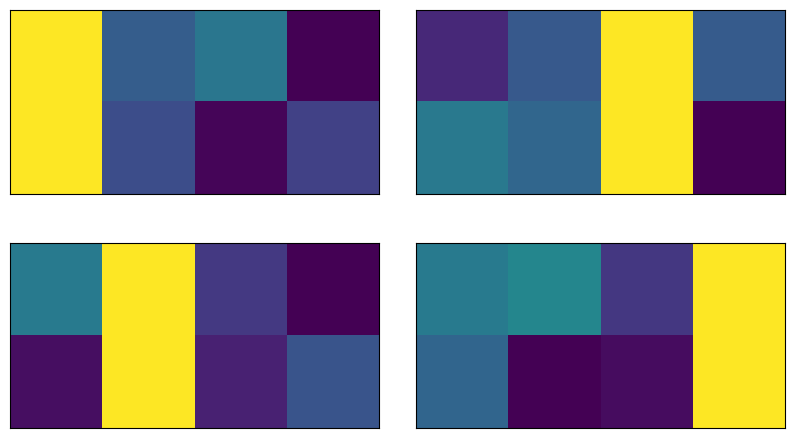

Generated images and labels:
Number of images: 100
Sample image (flattened): [0.48594876 1.57079633 1.57079633 0.03803671 0.67372586 0.29667335
 0.16659917 0.57528618]
Sample label: -1


In [8]:
def generate_dataset(num_images):
    """
    Generate a dataset with specified patterns of horizontal and vertical lines.

    Each image in the dataset is either a representation of a horizontal or vertical line.
    The patterns are filled with a specific value (π/2), and random noise is added to blank spaces.

    Parameters:
        num_images (int): The number of images to generate.

    Returns:
        tuple: Two lists containing the images and their corresponding labels.
    """
    # Predefined arrays for horizontal and vertical patterns
    hor_array = np.zeros((6, 8))  # Horizontal lines, 6 different configurations
    ver_array = np.zeros((4, 8))  # Vertical lines, 4 different configurations

    # Create horizontal line patterns
    for row in range(6):
        if row != 3:  # Skip the middle to make a break in the pattern
            hor_array[row, row:row+2] = np.pi / 2  # Set two consecutive cells

    # Create vertical line patterns
    for row in range(4):
        ver_array[row, [row, row + 4]] = np.pi / 2  # Set two separated cells aligned vertically

    # Generate the dataset
    images, labels = [], []
    for _ in range(num_images):
        # Randomly choose to use a horizontal or vertical line pattern
        if algorithm_globals.random.integers(0, 2) == 0:  # Horizontal
            labels.append(-1)
            selected_index = algorithm_globals.random.integers(0, len(hor_array))
            images.append(np.array(hor_array[selected_index]))
        else:  # Vertical
            labels.append(1)
            selected_index = algorithm_globals.random.integers(0, len(ver_array))
            images.append(np.array(ver_array[selected_index]))

        # Add random noise to non-zero elements of the image
        noise_mask = images[-1] == 0
        images[-1][noise_mask] = algorithm_globals.random.uniform(0, np.pi / 4, size=noise_mask.sum())

    return images, labels

# Generate dataset
images, labels = generate_dataset(100)

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.25, random_state=100
)

# Visualization of the first few training images
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Ensure correct shape for visualization 
        aspect='equal'
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)
plt.show()

print("Generated images and labels:")
print("Number of images:", len(images))
print("Sample image (flattened):", images[0])
print("Sample label:", labels[0])

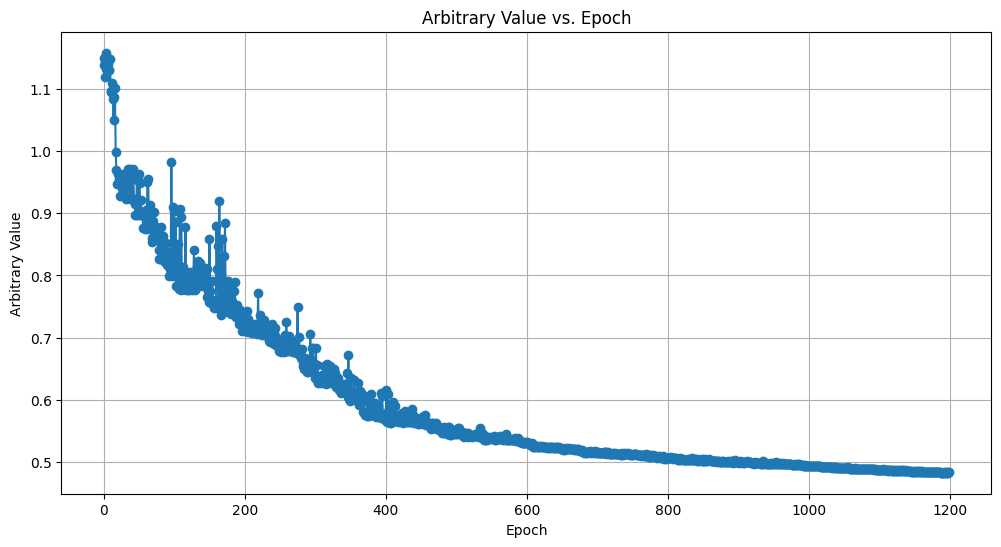

Accuracy from the train data: 94.67%
Accuracy from the test data: 92.0%


In [9]:
def callback_graph(weights, obj_func_eval):
    """
    Callback function to display the training progress.
    
    Parameters:
        weights (ndarray): Current weights of the quantum classifier.
        obj_func_eval (float): Current value of the objective function.
    """
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.figure(figsize=(12, 6))
    plt.title("Arbitrary Value vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Arbitrary Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals, marker='o')
    plt.grid(True)
    plt.show()

# Initializing the classifier with the QNN and the COBYLA optimizer
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=300),  # Sets maximum iterations for the optimizer
    callback=callback_graph,
)

# Convert training data to NumPy arrays for processing
train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)

# List to store values of the objective function after each iteration
objective_func_vals = []

# Train the quantum neural network classifier
classifier.fit(train_images, train_labels)

# Evaluate the classifier on the training data
train_accuracy = np.round(100 * classifier.score(train_images, train_labels), 2)
print(f"Accuracy from the train data: {train_accuracy}%")

# Evaluate the classifier on the test data
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)
test_accuracy = np.round(100 * classifier.score(test_images, test_labels), 2)
print(f"Accuracy from the test data: {test_accuracy}%")

Accuracy from the test data: 92.0%


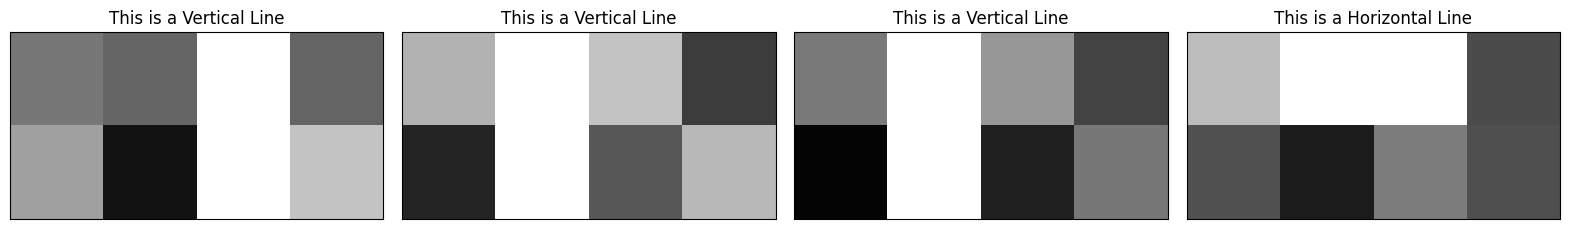

In [13]:
# Predict the labels for the test dataset
y_predict = classifier.predict(test_images)

# Convert the list of test images and labels to numpy arrays for processing
x = np.asarray(test_images)
y = np.asarray(test_labels)

# Calculate and print the accuracy of the classifier on the test dataset
test_accuracy = np.round(100 * classifier.score(x, y), 2)
print(f"Accuracy from the test data: {test_accuracy}%")

# Visualization of some examples from the test dataset
fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'xticks': [], 'yticks': []})
for i in range(4):  # Display the first four images
    img = test_images[i+3].reshape(2, 4) * 500  # Reshape image to 2x4 for display
    ax[i].imshow(img, cmap='gray', aspect='equal', vmin=1, vmax=500)
    label = "Horizontal Line" if y_predict[i+3] == -1 else "Vertical Line"
    ax[i].set_title(f"This is a {label}")
plt.subplots_adjust(wspace=0.05)
plt.savefig("TestRes.png")
plt.show()
